**Practically understanding  Siamese Network**

In [1]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input,Flatten,Dense,Lambda,Dropout,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras import backend as K
import numpy as np
import random

Using TensorFlow backend.


In [0]:
num_classes=10
epochs=20

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [0]:
def contrastive_loss(y_true, y_pred):
    '''
    loss function to group similar classes together and dissimilar far away
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


In [0]:
def create_pairs(x, digit_indices):
    '''
    Creating the pair of inputs such that each pair containes two same class images 
    and two different class images
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1,28,28,1).astype('float32')
x_test = x_test.reshape(-1,28,28,1).astype('float32')
'''
normalizing the data by dividing the maximimum value
'''
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

11493376/11490434 [==============================] - 2s 0us/step


In [8]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
digit_indices

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975]),
 array([    0,    11,    35, ..., 59968, 59993, 59997]),
 array([   13,    18,    32, ..., 59982, 59986, 59998]),
 array([   15,    29,    38, ..., 59963, 59977, 59988]),
 array([   17,    31,    41, ..., 59989, 59995, 59999]),
 array([    4,    19,    22, ..., 59973, 59990, 59992])]

In [0]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)


In [0]:
def create_base_network(input_shape):
    '''
    creating the CNN network that will be shared by two inputs
    '''
    input = Input(shape=input_shape)
    conv1=Conv2D(filters=32,kernel_size=(3,3),input_shape=(28,28),activation='relu')(input)
    maxpool1=MaxPool2D(pool_size=(2,2))(conv1)
    conv2=Conv2D(filters=64,kernel_size=(3,3),activation='relu')(maxpool1)
    maxpool2=MaxPool2D(pool_size=(2,2))(conv2)
    x = Flatten()(maxpool2)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [0]:
def eucl_dist_output_shape(shapes):
    '''
    determine the shape of output from the siamese network
    '''
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


In [0]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [14]:
base_network = create_base_network(input_shape) # creating the base network 

input_a = Input(shape=input_shape) 
input_b = Input(shape=input_shape)

W0801 05:54:48.269037 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 05:54:48.319283 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 05:54:48.327573 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 05:54:48.365509 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0801 05:54:48.414939 140343816329088 deprecation_wrapp

In [0]:
'''
same base network is shared by tow inputs
'''
processed_a = base_network(input_a) 
processed_b = base_network(input_b)

In [0]:
'''
using euclidean distance as the distance measure for finding the similarity
'''
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

In [0]:
model = Model([input_a, input_b], distance)

In [18]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

W0801 05:54:59.566047 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          256768      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [20]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=10,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

W0801 05:55:06.825398 140343816329088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 05:55:07.188821 140343816329088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 108400 samples, validate on 17820 samples
Epoch 1/10
108400/108400 [==============================] - 20s 184us/step - loss: 0.0461 - accuracy: 0.9566 - val_loss: 0.0101 - val_accuracy: 0.9886
Epoch 2/10
108400/108400 [==============================] - 14s 128us/step - loss: 0.0091 - accuracy: 0.9906 - val_loss: 0.0085 - val_accuracy: 0.9902
Epoch 3/10
108400/108400 [==============================] - 14s 128us/step - loss: 0.0058 - accuracy: 0.9937 - val_loss: 0.0084 - val_accuracy: 0.9901
Epoch 4/10
108400/108400 [==============================] - 14s 128us/step - loss: 0.0041 - accuracy: 0.9957 - val_loss: 0.0100 - val_accuracy: 0.9878
Epoch 5/10
108400/108400 [==============================] - 14s 128us/step - loss: 0.0031 - accuracy: 0.9965 - val_loss: 0.0079 - val_accuracy: 0.9907
Epoch 6/10
108400/108400 [==============================] - 14s 127us/step - loss: 0.0027 - accuracy: 0.9970 - val_loss: 0.0067 - val_accuracy: 0.9925
Epoch 7/10
108400/108400 [=================

In [0]:
model.save('MNIST_siamese_model.h5')

In [0]:
from keras.models import load_model
M1=load_model('MNIST_siamese_model.h5',custom_objects={'contrastive_loss':contrastive_loss})
'''
Here the last layer of actual siamese network is removed such that we can visualize the mapping done my siamese network
for similar classes and dissimilar classes
'''

In [24]:
M1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          256768      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [25]:
M1.layers.pop()
M1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          256768      input_2[0][0]                    
                                                                 input_3[0][0]                    
Total params: 256,768
Trainable params: 256,768
Non-trainable params: 0
__________________________________________________________________________________________________


**visulazing the siamese network output**

1.   Actual MNIST data images are applied tsne dimensinality reduction algorithm (784 dimension to 2  dimension)
2.   Actual MNIST images are applied to trained siamese network and obtained the output. The obtained output is applied tsne algorithm (128 dimension to 2 dimension)

These images were scatter plotted below





In [0]:
from sklearn.manifold import TSNE
import seaborn as sb
tsne=TSNE()

In [0]:
x_train_flat=x_train[:512].reshape(-1,784)
tsne_train_output=tsne.fit_transform(x_train_flat)

In [0]:
import matplotlib.pyplot as plt

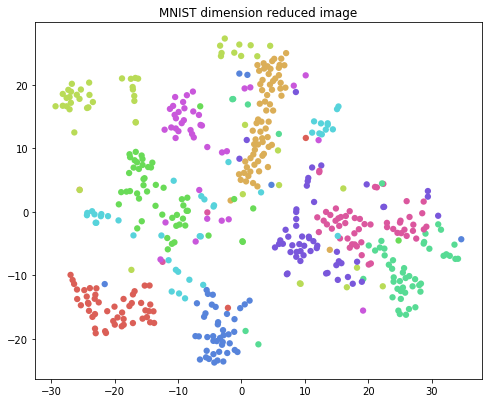

In [65]:
palette = np.array(sb.color_palette("hls", 10))
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
ax.set_title("MNIST dimension reduced image")
sc = ax.scatter(tsne_train_output[:,0], tsne_train_output[:,1], lw=0, s=40,
                    c=palette[y_train[:512].astype(np.int)])

In [0]:
trained_model = Model(inputs=input_a, outputs=processed_a)

In [0]:
trained_model.load_weights('MNIST_siamese_model.h5')

In [0]:
pred=np.abs(trained_model.predict(x_train[:512]))
tsne1=TSNE()
model_tsne=tsne1.fit_transform(pred)

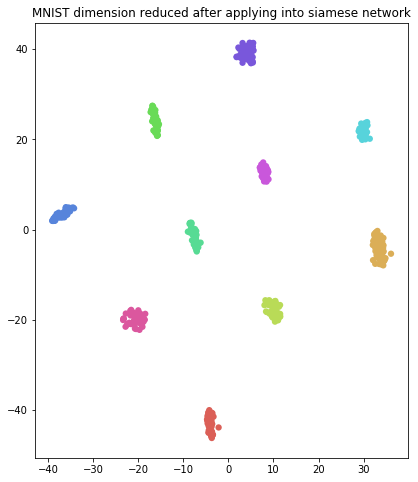

In [66]:
palette = np.array(sb.color_palette("hls", 10))
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
ax.set_title("MNIST dimension reduced after applying into siamese network")
sc = ax.scatter(model_tsne[:,0], model_tsne[:,1], lw=0, s=40,
                    c=palette[y_train[:512].astype(np.int)])

In [71]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

**Interpreting the output of siamese network for similar class images**

Following there are two images which belongs to same class i.e 1. The images were fed into siamese network and applied tsne algorithm and were scatter plotted. 

The output shows these two data points are present very close 


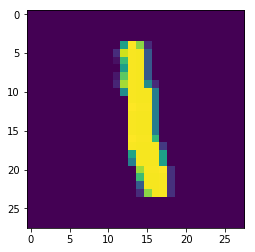

In [99]:
plt.imshow(x_train[6,:].reshape(28,28))

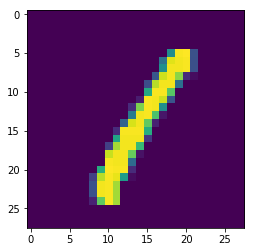

In [100]:
plt.imshow(x_train[3,:].reshape(28,28))

In [101]:
img=trained_model.predict(x_train[[3,6],:])
img.shape

(2, 128)

In [102]:
model.predict([x_train[3,:].reshape(1,28,28,1),x_train[6,:].reshape(1,28,28,1)])

array([[0.00150249]], dtype=float32)

In [103]:
from scipy.spatial import distance
distance.euclidean(img[0,:],img[1,:])

0.0015024919994175434

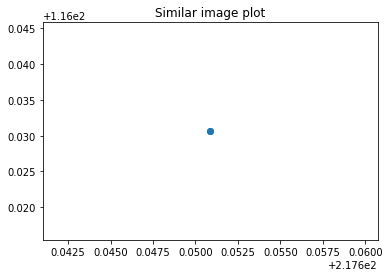

In [124]:
Ts=TSNE()
tester_trans=np.abs(Ts.fit_transform(img))
plt.title("Similar image plot")
plt.scatter(tester_trans[:,0],tester_trans[:,1])

In [105]:
tester_trans

array([[9655.106 , 1872.7156],
       [9655.106 , 1872.7156]], dtype=float32)

**Interpreting the ouput of siamese network with different class images**

Following are the two images that belongs to different classes (i.e 0,1). These images were fed into siamese network and scatter plotted.

The plot shows that these image data points were sepreated from each other


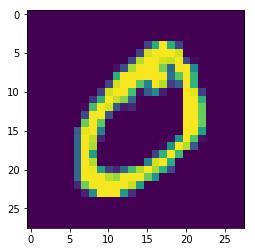

In [106]:
plt.imshow(x_train[1,:].reshape(28,28))

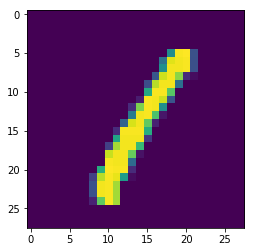

In [107]:
plt.imshow(x_train[3,:].reshape(28,28))

In [118]:
img1=trained_model.predict(x_train[[1,3],:])
img1.shape

(2, 128)

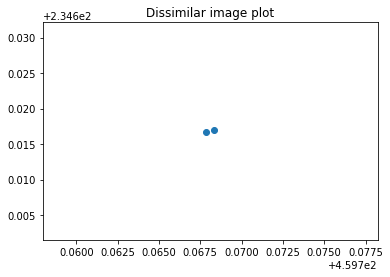

In [125]:
Ts1=TSNE()
tester_trans1=np.abs(Ts1.fit_transform(img1))
plt.title("Dissimilar image plot")
plt.scatter(tester_trans1[:,0],tester_trans1[:,1])

In [120]:
tester_trans1

array([[131.2214  ,  61.73695 ],
       [131.2219  ,  61.736706]], dtype=float32)

In [121]:
model.predict([x_train[1,:].reshape(1,28,28,1),x_train[3,:].reshape(1,28,28,1)])

array([[1.327484]], dtype=float32)

In [123]:
from scipy.spatial import distance
distance.euclidean(img1[0,:],img1[1,:])

1.3274840116500854